In [1]:
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from hummingbird.ml import convert, load
import os
import pandas as pd

In [2]:
file_path = '/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/002_MSL_id_1_Sensor_tr_500_1st_900.csv'
#file_path = '/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M/173_GECCO_id_1_Sensor_tr_16165_1st_16265.csv'
df = pd.read_csv(file_path)
data = df.iloc[:, :-1].values

In [3]:
kpca_model = KernelPCA(kernel='rbf', n_components=data.shape[1])

In [4]:
kpca_model.fit(data)

KernelPCA(kernel='rbf', n_components=55)

In [5]:
kpca_pytorch = convert(kpca_model, 'torch')
kpca_pytorch.to('cuda')

In [6]:
import time
start = time.time()
for i in range(data.shape[1]):
    dummy_model = kpca_model.transform(data[:-1])
end = time.time()
print(f"Time taken for {data.shape[1]} iterations: {end - start} seconds")

Time taken for 55 iterations: 2.946162223815918 seconds


In [7]:
start = time.time()
for i in range(data.shape[1]):
    dummy_torch = kpca_pytorch.transform(data[:-1])
end = time.time()
print(f"Time taken for {data.shape[1]} iterations with PyTorch: {end - start} seconds")

Time taken for 55 iterations with PyTorch: 0.6412408351898193 seconds


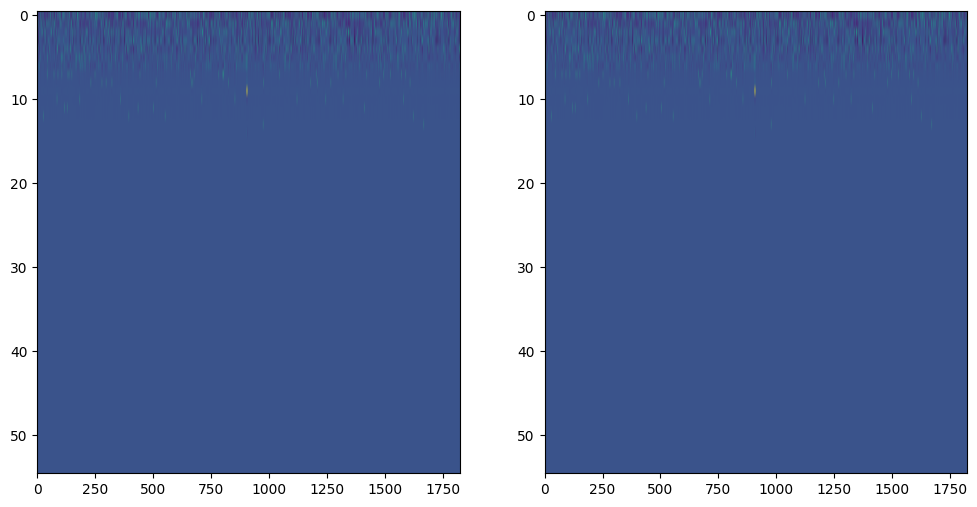

In [8]:
import matplotlib.pyplot as plt

viz_model = dummy_model.transpose(1, 0)
viz_torch = dummy_torch.transpose(1, 0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# imshow
axes[0].imshow(viz_model, aspect='auto', cmap='viridis')
axes[1].imshow(viz_torch, aspect='auto', cmap='viridis')

In [9]:
base_transform = kpca_pytorch.transform(data)
base_var = np.var(base_transform, axis=0).sum()
importances = []

for c in range(data.shape[1]):
    masked_data = data.copy()
    masked_data[:, c] = 0  # 채널 c 제거
    try:
        transformed_masked = kpca_pytorch.transform(masked_data)
        masked_var = np.var(transformed_masked, axis=0).sum()
        importance = base_var - masked_var  # 제거 시 variance 감소량
    except:
        importance = 0.0
    importances.append(importance)

importances = np.array(importances)
importances = importances / (np.sum(importances) + 1e-8)  # normalize

# KMeans 클러스터링
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
labels = kmeans.fit_predict(importances.reshape(-1, 1))  # shape: (C,)

# 가장 중요한 채널이 속한 클러스터 선택
sorted_indices = np.argsort(importances)[::-1]
important_label = labels[sorted_indices[0]]
selected_indices = np.where(labels == important_label)[0]

# 선택된 채널만 남기기
print(f"Selected channels: {selected_indices}")

Selected channels: [ 5 11 35 39 47 49]
